In [1]:
%matplotlib inline

# Validation curves: plotting scores to evaluate models
based on original [documentatio](http://scikit-learn.org/stable/modules/learning_curve.html)

bias, variance and noise

[Bias–variance dilemma](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model, model_selection, naive_bayes, pipeline, preprocessing, svm

## Underfitting vs. Overfitting

MSE - [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)

$$
{E}{\Big [}{\big (}y-{\hat  {f}}(x){\big )}^{2}{\Big ]} = {\mathrm  {Bias}}{\big [}{\hat  {f}}(x){\big ]}^{2}+{\mathrm  {Var}}{\big [}{\hat  {f}}(x){\big ]}+\sigma ^{2}
$$

Where:
$$
{\displaystyle {\begin{aligned}\mathrm {Bias} {\big [}{\hat {f}}(x){\big ]}=\mathrm {E} {\big [}{\hat {f}}(x)-f(x){\big ]}\end{aligned}}}
$$

and

$$
{\displaystyle {\begin{aligned}\mathrm {Var} {\big [}{\hat {f}}(x){\big ]}=\mathrm {E} [{\hat {f}}(x)^{2}]-\mathrm {E} [{\hat {f}}(x)]^{2}\end{aligned}}}
$$
*TODO*: could we calc bias and variance?

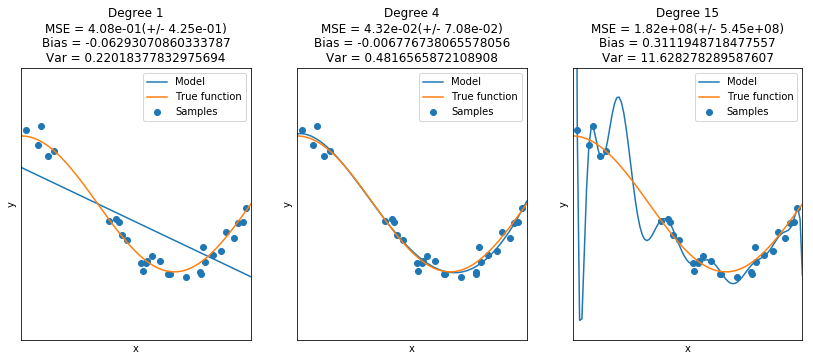

In [3]:
np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X)

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = preprocessing.PolynomialFeatures(degree=degrees[i],
                                                           include_bias=False)
    linear_regression = linear_model.LinearRegression()
    pipeline_reg = pipeline.Pipeline([("polynomial_features", polynomial_features),
                                      ("linear_regression", linear_regression)])

    # Evaluate the models using crossvalidation
    scores = model_selection.cross_val_score(pipeline_reg, X[:, np.newaxis], y,
                                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)

    pipeline_reg = pipeline_reg.fit(X[:, np.newaxis], y)

    plt.plot(X_test, pipeline_reg.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    bias = (pipeline_reg.predict(X_test[:, np.newaxis]) - true_fun(X_test)).mean()
    predict_y = pipeline_reg.predict(X_test[:, np.newaxis])
    variance = (predict_y * predict_y).mean() - predict_y.mean() * predict_y.mean()
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})\nBias = {}\nVar = {}".format(
        degrees[i], -scores.mean(), scores.std(), bias, variance))
plt.show()

## Plotting Validation Curves

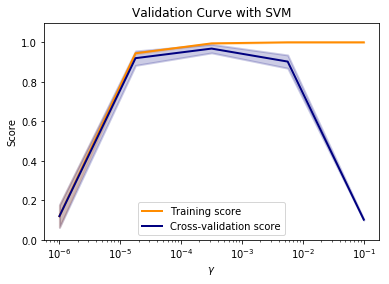

In [4]:
digits = datasets.load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = model_selection.validation_curve(
    svm.SVC(), X, y, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)

lw = 2

plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Plotting Learning Curves

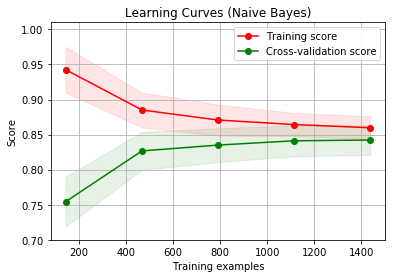

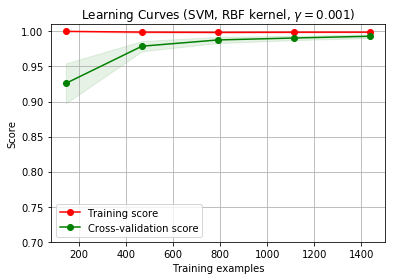

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = datasets.load_digits()
X, y = digits.data, digits.target

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = model_selection.ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = naive_bayes.GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = svm.SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()